# Assignment 3: Binary options, Barrier options, and Implied volatility on the Heston model

#### Job Marcelis, Ernani Hazbolatow, Koen Verlaan
#### May 19, 2025 University of Amsterdam

In [1]:
from src.binary_PDE import *
from src.heston_calibration import *

#### Binary options

In [ ]:
# Main simulation settings
Nx = 100
Nt = 100
S0 = 1
r = 0.05
sigma = 0.2
K = 1.05
T = 1
num_paths = 10000
seed = 420
q = 2*r/sigma**2
a = 0.5*(q - 1)
b = 0.25*(q + 1)**2
xmax = 1
x = np.linspace(-xmax, xmax, Nx)
tau = np.linspace(0, 0.5*sigma**2 * T, Nt)

Below we compute the binary option price using the analytical formula, Monte Carlo simulations, the Backward-Time-Central-Space (BTCS) scheme, and the Crank-Nicolson (CN) scheme. This is done at $S_0 = 1$ and as a function of time. Since the $K > S_0$, the price approaches 0 as $T \rightarrow 1$. If $K < S_0$, the price would become 1.

In [ ]:
Nt = 40
tau = np.linspace(0, 0.5*sigma**2 * T, Nt)

######## Analytical Price and Monte Carlo price ##############
time = np.linspace(0, 0.999, 20)
analytical_prices = np.zeros(len(time))
MC_prices = np.zeros_like(analytical_prices)
MC_CIs = np.zeros_like(analytical_prices)
for i, T in enumerate(time):
    price = closed_form_price(1-T, r, sigma, K, S0)
    MC_price, MC_CI = MC_binary_price(num_paths, 1-T, r, sigma, K, S0, seed+i)

    analytical_prices[i] = price
    MC_prices[i] = MC_price
    MC_CIs[i] = MC_CI

########## BTCS price ############
result_BTCS = BTCS_scheme(K, x, tau, q, a, b)
x0 = np.log(S0 / K)
y_at_x0 = np.zeros(len(tau))
for n in range(len(tau)):
    f = interp1d(x, result_BTCS[n, :], kind='linear', fill_value='extrapolate')
    y_at_x0[n] = f(x0)
C_at_S0_BTCS = K * y_at_x0 * np.exp(-a*x0 - b*tau)
t_vals = T - 2*tau / sigma**2

############ CN price ##############
result_CN = CN_scheme(K, x, tau, q, a, b)
y_at_x0 = np.zeros(len(tau))
for n in range(len(tau)):
    f = interp1d(x, result_CN[n, :], kind='linear', fill_value='extrapolate')
    y_at_x0[n] = f(x0)
C_at_S0_CN = K * y_at_x0 * np.exp(-a*x0 - b*tau)


plt.figure(figsize=(7,5), dpi=300)
plt.scatter(t_vals, C_at_S0_BTCS, color='black', label='BTCS Scheme', marker='v')
plt.scatter(t_vals, C_at_S0_CN, color='green', label='CN Scheme', marker='s')
plt.scatter(time, analytical_prices, label='Analytical', color='red', marker='*', zorder=5)
plt.errorbar(time, MC_prices, yerr=MC_CIs, fmt='o', label='MC', color='blue')
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$C(t, S=1)$', fontsize=16)
plt.title(r'Time evolution of Binary Call for $S_0=1$, $K=1.05$', fontsize=17)
plt.grid(ls='dashed')
plt.tick_params(axis='both', labelsize=13)
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

Below is the option price surface as a function of t and S.

In [ ]:
Nt = 100
tau = np.linspace(0, 0.5*sigma**2 * T, Nt)
result_CN = CN_scheme(K, x, tau, q, a, b)

plot_option_surface(result_CN, tau, x, T, K, sigma, a, b)

To explore the parameter space, we vary $K$ and $\sigma$ between reasonable values while keeping the rest constant, we then set $t=0$ and plot the option price vs. $K$ and $S$, and $\sigma$ and $S$, respectively.

In [ ]:
K_vals = np.linspace(0.8, 1.2, 40)
K_mesh, S_mesh, C_surface = sens_analysis(x, tau, Nx, r, sigma, K, K_vals, parameter_to_vary='K')

fig = plt.figure(figsize=(10, 7), dpi=300)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(K_mesh, S_mesh, C_surface, cmap='viridis', edgecolor='none')
ax.set_xlabel(r'$K$', fontsize=16, labelpad=10)
ax.set_ylabel(r'$S$', fontsize=16, labelpad=10)
ax.set_zlabel(r'$C(t=0,S;K)$', fontsize=16, labelpad=10)
ax.set_title(r'Binary Call Price vs $S$ and $K$', fontsize=18, pad=10)
ax.tick_params(axis='both', labelsize=14)
cbar = fig.colorbar(surf, shrink=0.4, aspect=10, pad=0.05)
cbar.set_label('Binary Option Price', fontsize=14, labelpad=5)
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

In [ ]:
sigma_vals = np.linspace(0.05, 0.5, 20)
sigma_mesh, S_mesh, C_surface = sens_analysis(x, tau, Nx, r, sigma, K, sigma_vals, parameter_to_vary='sigma')

fig = plt.figure(figsize=(10, 7), dpi=300)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(sigma_mesh, S_mesh, C_surface, cmap='viridis', edgecolor='none')
ax.set_xlabel(r'$\sigma$', fontsize=16, labelpad=10)
ax.set_ylabel(r'$S$', fontsize=16, labelpad=10)
ax.set_zlabel(r'$C(t=0,S)$', fontsize=16, labelpad=10)
ax.set_title(r'Binary Call Price vs $\sigma$ and $S$', fontsize=18, pad=10)
ax.tick_params(axis='both', labelsize=14)
cbar = fig.colorbar(surf, shrink=0.4, aspect=10, pad=0.05)
cbar.set_label('Binary Option Price', fontsize=14, labelpad=5)
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

Finally, we compute the option $\Delta$ using the analytical formula as well as the approximated $\Delta$ from the crank-nicolson results.

In [ ]:
S_grid = K * np.exp(x)
delta_a = digital_delta_analytic(r, sigma, S_grid, K, T)

C_grid = K * result_CN[-1, :] * np.exp(-a*x - b*tau[-1])
delta_CN = np.gradient(C_grid, S_grid)

plt.figure(figsize=(7, 5), dpi=300)
plt.title(r'Option $\Delta$ of a Binary Option', fontsize=17)
plt.plot(S_grid, delta_CN, label='CN Δ', color='blue')
plt.plot(S_grid, delta_a,  '--', label='Analytic Δ', color='red')
plt.legend(fontsize=12)
plt.xlabel(r'$S$', fontsize=15)
plt.ylabel(r'$\Delta$', fontsize=15)
plt.tight_layout()
plt.grid(ls='dashed')
plt.tick_params(axis='both', labelsize=13)
plt.show()

### Heston Model Calibration for SP500

In the cells below we will calibrate the Heston models five paramters to replicate the observed market implied volatility surface of the SP500.

We start with loading the data from the provided datasource for two specific days. 

The calibrate_heston function then uses the L-BFGS-B optimization algorithm. This optimizer  adjusts the Heston parameters to minimize an objective function, which is primarily the Mean Squared Error (MSE) between market and model implied volatilities, augmented by a penalty for violations of the Feller condition.

The plots then shows the actual implied volatility surface and the calibrated one.


Calibration Results:
MSE: 0.005040
RMSE: 0.070993


array([[0.37545675, 0.37339447, 0.36630049, 0.35213794, 0.33357202,
        0.31775376, 0.30424385, 0.28280721, 0.26705402, 0.2553164 ,
        0.24636774],
       [0.3425225 , 0.3451816 , 0.33797161, 0.3247575 , 0.30760395,
        0.29316247, 0.28100193, 0.26216669, 0.24877478, 0.2390539 ,
        0.23177448],
       [0.32506256, 0.31789276, 0.31115582, 0.29889905, 0.28317387,
        0.27015585, 0.25941527, 0.24331335, 0.23231326, 0.2245522 ,
        0.21884863],
       [0.29791121, 0.29121281, 0.28496833, 0.27371235, 0.25952048,
        0.24807534, 0.23891902, 0.22578181, 0.2172294 , 0.21138734,
        0.20718718],
       [0.27050903, 0.26432418, 0.25861319, 0.24847257, 0.23606244,
        0.22649067, 0.21918626, 0.20930461, 0.20325357, 0.19929259,
        0.19653341],
       [0.25644655, 0.25053782, 0.24512206, 0.23562061, 0.22427278,
        0.21581285, 0.20956145, 0.2014166 , 0.1966281 , 0.1935909 ,
        0.19152952],
       [0.24199522, 0.23638074, 0.23129041, 0.22251995, 0.

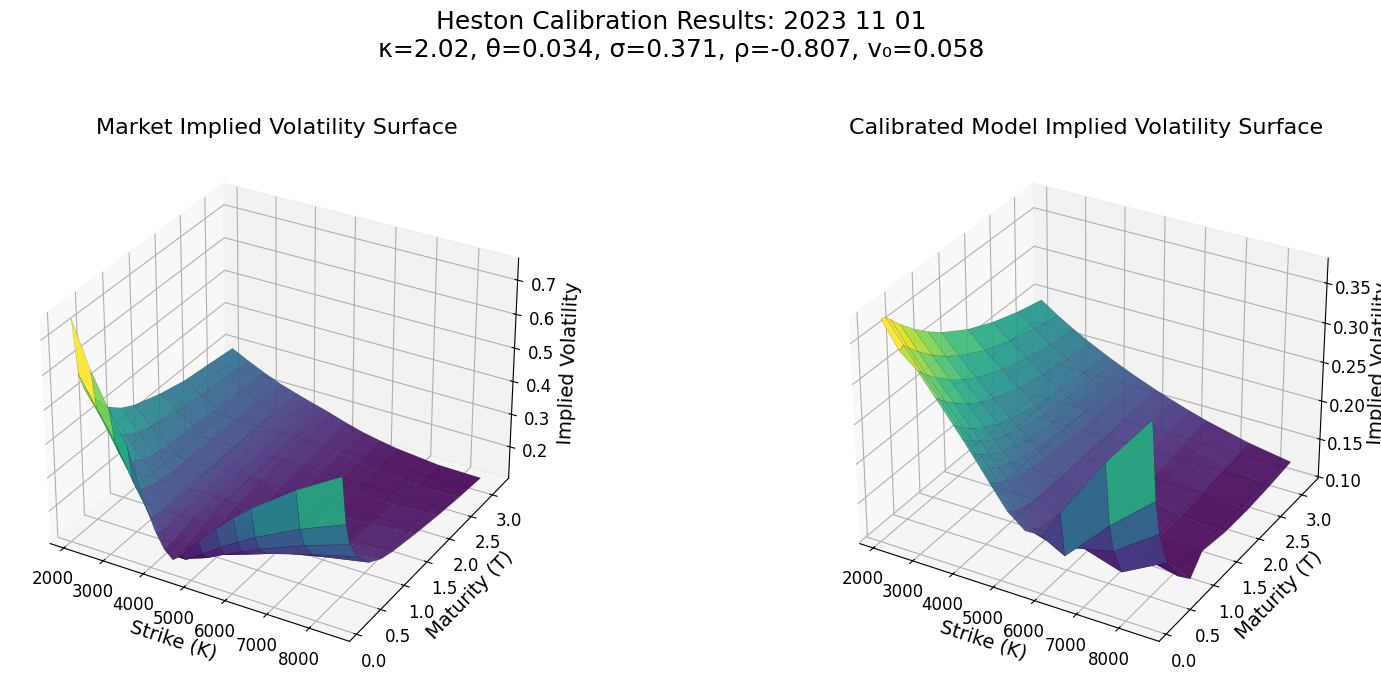

In [2]:
market_data = load_market_data("2023 11 01")
initial_guess = np.array([2.0, 0.05, 0.20, -0.7, 0.04]) 

S0_market = 4327.86

result = calibrate_heston(market_data, S0_market=S0_market, r_market=0.01)
analyze_and_plot(market_data, S0_market, 0.01, result[0], "2023 11 01")


Calibration Results:
MSE: 0.007109
RMSE: 0.084313


array([[0.36425881, 0.25787925, 0.28515976, 0.28376173, 0.27711973,
        0.27139006, 0.26648725, 0.25867301, 0.25285589, 0.24844721,
        0.24503803],
       [0.26980235, 0.26924409, 0.26753183, 0.26566201, 0.26062783,
        0.25637807, 0.2527884 , 0.24715927, 0.24304015, 0.23995456,
        0.23758652],
       [0.25237485, 0.25156491, 0.25023828, 0.24898903, 0.24567237,
        0.24291948, 0.24062856, 0.23709495, 0.23454736, 0.23265478,
        0.23120886],
       [0.2352063 , 0.23455125, 0.23393832, 0.23336598, 0.2318711 ,
        0.23065833, 0.22966587, 0.22815406, 0.22706871, 0.22626029,
        0.22563995],
       [0.21799485, 0.21819612, 0.21838352, 0.21855865, 0.21901997,
        0.21939632, 0.2196987 , 0.22012959, 0.22040283, 0.22058228,
        0.22070573],
       [0.20956248, 0.21023717, 0.21086106, 0.21143835, 0.21292603,
        0.21410819, 0.21505008, 0.21641609, 0.2173296 , 0.21796944,
        0.21843741],
       [0.20127522, 0.20244925, 0.20352955, 0.20452358, 0.

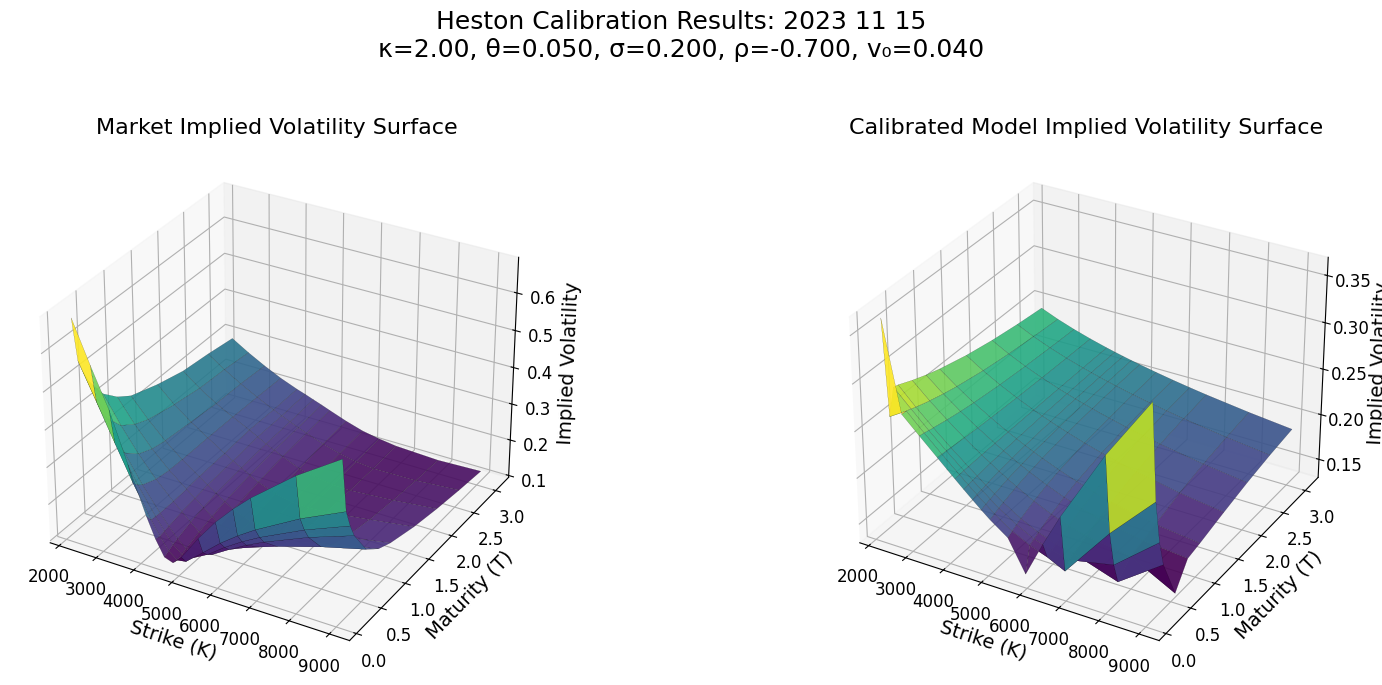

In [3]:
market_data = load_market_data("2023 11 15")
initial_guess = np.array([2.0, 0.05, 0.218, -0.703, 0.052]) 

S0_market = 4502.88

result = calibrate_heston(market_data, S0_market=S0_market, r_market=0.01)
analyze_and_plot(market_data, S0_market, 0.01, result[0], "2023 11 15")